In [1]:
import pandas as pd
import numpy as np
import itertools
import string
import json
import glob
import re

#Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#NLPT
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Plotting charts
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA


# tqdm.notebook.tqdm
from tqdm.notebook import tqdm

C:\Users\65987\anaconda3\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
C:\Users\65987\anaconda3\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\65987\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


### 1) TF-IDF

In [2]:
df = pd.read_csv('sentiment_data_file_path')

In [3]:
df.head(1)

,id,predicted score,Product,Customer Name,Date of Review,Country,Review,Product URL,Rating,predicted sentiment,actual sentiment
0,0,4,Original Cleansing Face Wipes • 20 wipes,Kerish Albano,13-Jun-23,Australia,coconut wipe It does remove my makeup but had ...,https://www.sephora.sg/products/sephora-collec...,3.5,positive,neutral


In [3]:
#text preprocessing
def remove_special_characters(text):
    filtered_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return filtered_text

stop_words = stopwords.words('english')
def remove_stopwords(filtered_text):
    tokens = nltk.word_tokenize(filtered_text)
    stopword_removed = [token.lower() for token in tokens if token.lower() not in stop_words] #Tokenized and case normalized
    return stopword_removed

def exclude_list(stopwords_removed_list):
    exclude_list = ['ill', 'pia', 'would', 'le', 'yes', 'nada', 'tbh', 'ac', 'ch', 'say', 
                    'id', 'get', 'think', 'esp', 'saw', 'also', 'mr', 'still', 'im', 'gon', 
                    'na', 'btw', 'n', 'acc', 'lil', 'ive', 'p', 'le', 'meh', 'ig', 'v', 'm', 
                    'say', 'ie', 'use', 'using', 'used', 'product', 'make', 'get', 'go', 'maybe',
                   'probably', 'know', 'come', 'already', 'thought', 'there', 're']
    removed_exclude_list = [word for word in stopwords_removed_list if word not in exclude_list]
    return removed_exclude_list

lemmatizer = WordNetLemmatizer()
def lemmatize(removed_exclude_list):
    lemmatized_list = [lemmatizer.lemmatize(word) for word in removed_exclude_list]
    return lemmatized_list


def clean_document(text):
    filtered_text = remove_special_characters(text)
    stopwords_removed_list = remove_stopwords(filtered_text)
    removed_exclude_list = exclude_list(stopwords_removed_list)
    lemmatized_list = lemmatize(removed_exclude_list)
    
    word_list = []
    for words in lemmatized_list:
        word_list.append(words)
    corpus = " ".join(word_list)
    return corpus

In [4]:
df = df.drop_duplicates(subset='Review')
negative_df = df[df['predicted sentiment'] == 'negative']

In [6]:
negative_reviews = negative_df['Review'].tolist()

In [7]:
cleaned_docs = []
for r in tqdm(negative_reviews, total=len(negative_reviews)):
    corpus = clean_document(r)
    if corpus is not None:  # Check for NoneType object
        cleaned_docs.append(corpus)
    else:
        print("Encountered NoneType object for input:", r)

  0%|          | 0/50503 [00:00<?, ?it/s]

In [8]:
negative_df['Processed Reviews'] = cleaned_docs

C:\Users\65987\AppData\Local\Temp\ipykernel_13912\1140447960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df['Processed Reviews'] = cleaned_docs


### TF-IDF Vectorizer

In [9]:
vectorizer = TfidfVectorizer(
    lowercase=True,     #case normalization
    max_features=100,   #only consider top 100 freuqently occur words to reduce dimensionality
    max_df=0.8,         #ignore words appear more than 80%
    min_df=0.01,        #if word does not occur at least 5 times, completely ignored by the algorithm
    ngram_range=(1,3),  #single word to bigram (dry skin) to trigram (very dry skin)
    stop_words='english'
)

In [11]:
vectors = vectorizer.fit_transform(cleaned_docs)
# Convert sparse matrix to dense matrix
dense_matrix = vectors.toarray()

feature_names = vectorizer.get_feature_names_out()
dense = vectors.todense()
denselist = dense.tolist()
# all_keywords = []

# #Get the keywords of the entire description with respect to the corpus
# for description in tqdm(denselist, total=len(denselist)):
#     x=0
#     keywords = []
#     for word in description:
#         if word > 0:
#             keywords.append(feature_names[x])
#         x=x+1
#     all_keywords.append(keywords)

In [12]:
all_keywords

[['buy', 'dont', 'skin'],
 ['break',
  'didnt',
  'dont',
  'sensitive',
  'sensitive skin',
  'skin',
  'unfortunately',
  'work'],
 ['clean', 'dry', 'sensitive', 'sensitive skin', 'skin', 'smell'],
 ['clean', 'disappointed', 'doesnt', 'dry', 'face', 'good', 'try', 'wanted'],
 ['dont', 'dry', 'dry skin', 'money', 'recommend', 'skin', 'worth'],
 ['dont', 'dry', 'great', 'money', 'size', 'waste'],
 ['doesnt', 'face', 'makeup', 'really', 'recommend', 'skin'],
 ['better',
  'doesnt',
  'dont',
  'makeup',
  'money',
  'sensitive',
  'sensitive skin',
  'skin',
  'texture',
  'waste'],
 ['doesnt', 'dont', 'dry', 'face', 'makeup', 'recommend'],
 ['dry', 'face', 'price', 'wont', 'worth'],
 ['disappointed', 'dry', 'like', 'makeup', 'money', 'tried', 'waste'],
 ['definitely', 'face', 'money', 'smell', 'way'],
 ['dont', 'time', 'tried'],
 ['disappointed', 'good', 'makeup', 'skin'],
 ['broke', 'received', 'review', 'try'],
 ['didnt', 'face', 'like', 'lot', 'smell'],
 ['buy', 'change', 'new', 'ti

### 2) K-Means

In [19]:
inertia = []
scores = []
k_values = range(2, 20)
for k in tqdm(k_values, total=len(k_values)):
    kmeans = KMeans(n_clusters=k, init="k-means++", max_iter=100, n_init=1)
    kmeans.fit(dense_matrix)
    labels = kmeans.predict(dense_matrix)
    
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(dense_matrix, labels)
    ch_avg = calinski_harabasz_score(dense_matrix, labels)
    db_avg = davies_bouldin_score(dense_matrix, labels)
    
    scores.append([k, silhouette_avg, ch_avg, db_avg])

result = pd.DataFrame(scores, columns = ['k', 'SH', 'CH', 'DB'])
result


  0%|          | 0/18 [00:00<?, ?it/s]

,k,SH,CH,DB
0,2,0.022073,1375.829749,5.689999
1,3,0.024769,1141.412647,5.715905
2,4,0.021657,928.152770,5.355496
3,5,0.030859,1095.747467,4.531344
4,6,0.041836,1073.997862,4.251231
5,7,0.041760,1029.351917,4.260482
6,8,0.044696,979.559988,4.095880
7,9,0.041073,882.480999,4.279657
8,10,0.050140,883.031994,3.880868
9,11,0.050860,867.707525,4.096785


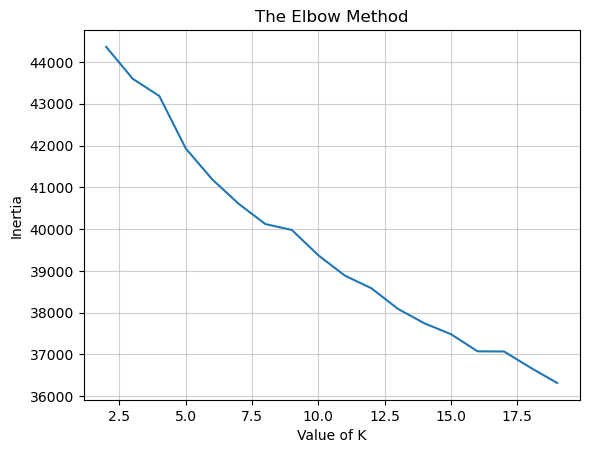

In [24]:
plt.plot(k_values, inertia)
plt.xlabel("Value of K")
plt.ylabel("Inertia")
plt.title("The Elbow Method")
plt.grid(alpha=0.6)
plt.show()

### 3) TF-IDF Evaluation

In [22]:
print(result.iloc[result['SH'].idxmax()], '\n')
print(result.iloc[result['CH'].idxmax()], '\n')
print(result.iloc[result['DB'].idxmin()])

k      16.000000
SH      0.061739
CH    771.106455
DB      3.588733
Name: 14, dtype: float64 

k        2.000000
SH       0.022073
CH    1375.829749
DB       5.689999
Name: 0, dtype: float64 

k      18.000000
SH      0.054989
CH    719.441896
DB      3.559399
Name: 16, dtype: float64


In [25]:
#Cluster the keywords to see overlaps
true_k = 16 #number of topics k
model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)
model.fit(dense_matrix)
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

In [27]:
#Write the data out
with open('k_16 clustering.txt', 'w', encoding='utf-8') as f:
    for i in range(true_k):
        f.write(f'Cluster{i}')
        f.write('\n')
        #first 10 words for each topics
        for ind in order_centroids[i, :10]:
            f.write(' %s' % terms[ind])
            f.write('\n')
        f.write('\n')
        f.write('\n')

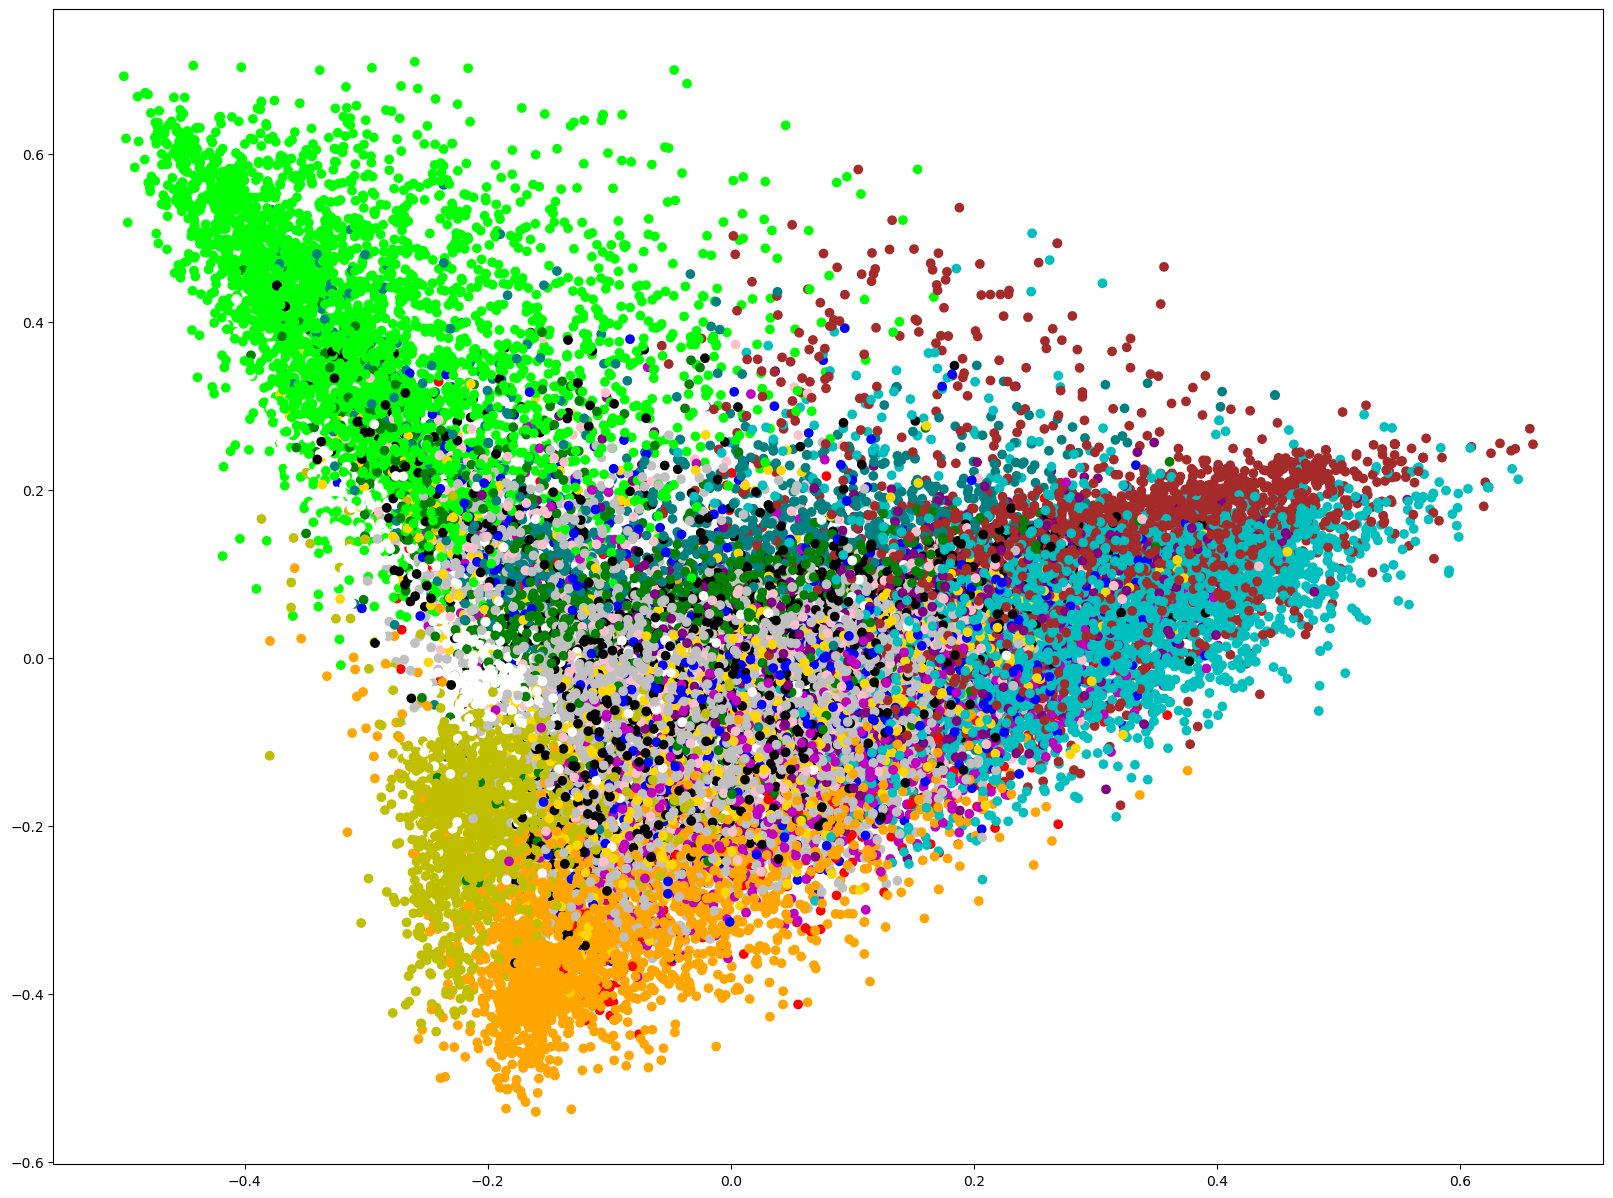

In [26]:
#plotting
kmean_indicies = model.fit_predict(vectors)
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(vectors.toarray())
colors = ['r', 'b', 'c', 'y', 'm', 'g', 'k', 'w', 'orange', 'purple',
          'brown', 'pink', 'teal', 'gold', 'silver', 'lime']
x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

fig, ax = plt.subplots(figsize=(20,15))
ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmean_indicies])

### Appending Cluster Data to DataFrame

In [28]:
negative_df['Clusters'] = kmean_indicies
tfidf_topics = negative_df['Clusters'].value_counts()

C:\Users\65987\AppData\Local\Temp\ipykernel_13912\1782159695.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df['Clusters'] = kmean_indicies


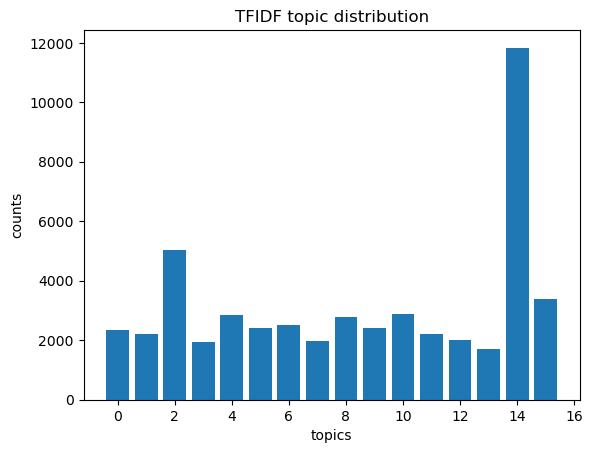

In [29]:
plt.bar(tfidf_topics.index, tfidf_topics)
plt.xlabel('topics')
plt.ylabel('counts')
plt.title('TFIDF topic distribution')
plt.show()

In [ ]:
negative_df[negative_df['Clusters'] == 6]['Review'][:10].tolist()